# 日本がサッカーW杯で優勝できる方法を過去の試合から分析してみた！！！！

## はじめに
こんにちは。機械学習初学者の石坂と申します。<br>

機械学習というと株やFX、仮想通貨の価格を分析、予測しているブログは多々ありますが <br>
私はW杯を分析してみたいと思いますが、なぜW杯なのか？ <br>

私が大のサッカー好きだからです（笑）
前回のロシアワールドカップも現FIFAランキング１位のベルギーに3対2まで接戦に持ち込み、残りわずかで敗れてしまいました。次回こそ優勝と目標を掲げている日本に、過去のデータを参考に優勝できる条件を<b>Pandas</b>メインに分析してみようと思います。
<br>
今回は下記URLのデータセットを参考にしております。<br>
https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017<br>

- **0 環境**
<br><br>
- **1-1 データの加工**
- **1-2 データの性質を理解する**
- **1-3 欠損値と重複データの確認**
<br><br>
- **2-1 特徴量の相関関係の分析**
- **2-2 データの可視化**
<br><br>
- **3-1 出場国チームの選別**
- **3-2 グループリーグの組み合わせ**
- **3-3 勝敗の決め方**
- **3-4 試合結果**
<br><br>
- **4 最後に**

## 0 環境

- **Python 3.7.4**
- **jupyter notebook 6.0.1**
- **macOS Mojave 10.14.6**

In [111]:
#importと部分はこのようになっております。
import pandas as pd
import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import os
import sys

## 1-1 データの加工

まず日本の勝敗を表記する<b>result</b>というカラムを作成します。<br>
このカラムは勝利［１］　引き分け［０］　敗北［−１］このように入力していきます。そこから日本戦のみ抽出したデータを作成していきます。

In [972]:
# 警告がうるさいためここでは非表示に設定
warnings.simplefilter("ignore")

# CSVの読み込み
df_match = pd.read_csv("match.csv")

# 日本がホームかアウェイかを示すjapan_home_dummy列を作成
df_match["japan_home_dummy"] = 0
df_match["japan_home_dummy"][df_match["home_team"]=="Japan"] = 1

# ホームチームが勝ったかどうかを示すhome_win列を作成
df_match["home_win"] = 0
df_match["home_win"][df_match["home_score"]>df_match["away_score"]] = 1
df_match["home_win"][df_match["home_score"]<df_match["away_score"]] = -1

# japan_home_dummy列とhome_win列の値に基づいてresult列を作成
df_match["result"] = 0
# 日本がホームかつホームの点数が高い場合
df_match["result"][(df_match["japan_home_dummy"]==1)&(df_match["home_win"]==1)] = 1
# 日本がホームかつアウェイの点数が高い場合
df_match["result"][(df_match["japan_home_dummy"]==1)&(df_match["home_win"]==-1)]= -1
# 日本がアウェイかつホームの点数が高い場合
df_match["result"][(df_match["japan_home_dummy"]==0)&(df_match["home_win"]==1)] = -1
# 日本がアウェイかつアウェイの点数が高い場合
df_match["result"][(df_match["japan_home_dummy"]==0)&(df_match["home_win"]==-1)] = 1

# 日本戦のみ抽出
df_japan = df_match.query('home_team == "Japan" | away_team == "Japan"')

## 1-2 データの性質を理解する

Pandasからデータの性質を分析していきます。このことは、データの前処理を行うかの方針を立てるために必要な作業です。<br>
- **どの特徴量がデータセットで使えるか**<br>
Pandasを使って、どのような変数（特徴量）が存在するのか、見てみます。プログラミングにおける変数と区別するために、以降、分析における変数は「特徴量」と記載します。まずはdf_japanの列名を確認してみます。データセットの列名が特徴量です。
<br><br>
- **どのようなデータが入っているか**<br>
では、df_japanのデータの中身を確認してみます。すべて見ると大変なので、先頭5行と、後ろから5行を見てみます。

In [377]:
#1. df_japanの特徴量（＝列名）を出力。
print(df_japan.columns.values)
#2. df_japanの最初から5行を出力。
df_japan.head(5)

['date' 'home_team' 'away_team' 'away_score' 'home_score' 'tournament'
 'city' 'country' 'neutral' 'japan_home_dummy' 'home_win' 'result']


,date,home_team,away_team,away_score,home_score,tournament,city,country,neutral,japan_home_dummy,home_win,result
454,1917-05-07,Japan,Philippines,15,2,Friendly,Tokyo,Japan,False,1,-1,-1
584,1921-05-30,Japan,Philippines,3,0,Friendly,Shanghai,China PR,True,1,-1,-1
713,1923-05-24,Japan,China PR,5,1,Friendly,Osaka,Japan,False,1,-1,-1
877,1925-05-20,China PR,Japan,0,2,Friendly,Manila,Philippines,True,0,1,-1
1068,1927-08-27,China PR,Japan,1,5,Friendly,Shanghai,China PR,False,0,1,-1


ここまでの作業で特徴量の値を確認できました。次は、欠損値を確認していきます。

## 1-3 欠損値と重複データの確認

infoメソッドから出力した値を見てみます。確認いただくとdf_japanでは、データが全624個（件）存在することが分かっています。<br>
データを確認すると欠損値が無いことを確認出来ましたので、今後欠損値を埋めていく作業は不要になります。<br>

In [378]:
#1. df_japanの全ての特徴量について、infoメソッドを利用して欠損値の有無を確認。
df_japan.info()
# 1. df_japanにdescribeメソッドを利用して、データの重複を確認。
df_japan.describe(include=['O'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 454 to 41372
Data columns (total 12 columns):
date                624 non-null object
home_team           624 non-null object
away_team           624 non-null object
away_score          624 non-null int64
home_score          624 non-null int64
tournament          624 non-null object
city                624 non-null object
country             624 non-null object
neutral             624 non-null bool
japan_home_dummy    624 non-null int64
home_win            624 non-null int64
result              624 non-null int64
dtypes: bool(1), int64(5), object(6)
memory usage: 59.1+ KB


,date,home_team,away_team,tournament,city,country
count,624,624,624,624,624,624
unique,624,78,103,16,164,63
top,2001-01-23,Japan,Japan,Friendly,Tokyo,Japan
freq,1,369,255,238,78,255


## 2-1 特徴量の相関関係の分析

特徴量<b>result</b>には、試合結果が格納されています。この特徴量に対し、<b>date</b>や特徴量<b>country</b>など他の特徴量がどの程度関係しているのか、調査する必要があります。関係を調べるために、相関を調べます。<br>
まずは`月別の勝率`を調べます。

In [379]:
#dateを文字からIndexDateFrameに変換
df_japan["date"] = pd.to_datetime(df_japan["date"])
df_japan.set_index("date", inplace=True)
#dateから新しく月別の”month”カラムを作成
df_m = df_japan.set_index([df_japan.index.month, df_japan.index])
df_m.index.names = ["month", "date"]
#月別のresultの合計を算出
df_m_only = df_m.sum(level="month")
df_m_only[["result"]].sort_values("result", ascending=False)

,result
month,
8,28
10,20
9,14
11,14
3,11
2,11
1,10
6,6
4,5


上記のランキングを確認すると日本は<b>８月が１番勝ちやすい</b>ということがわかります。次に国ごとの勝率を算出してみたいと思います。

In [ ]:
# 日本の勝率が高い国の辞書型データを作成
win_count_dct = {}
# 日本が勝ってる試合のみ抜き出せばいいのでresultが1の行のみを抽出
for index, row in df_japan[df_japan["result"]==1].iterrows():
    # まず敵国の国名を取得
    if row["japan_home_dummy"]==1:
        country = row["away_team"]
    else:
        country = row["home_team"]
    # すでに辞書にその国が登録されていれば勝利数を+1して登録済みでなければ登録と同時に勝利数1を記録
    if not country in win_count_dct:
        win_count_dct[country] = 1
    else:
        win_count_dct[country] += 1
# 勝利数が求まったので、勝率を求めるために試合回数を求める
# 辞書に登録されている各国ごとに試合回数を求めて、勝利数を割る
for country in win_count_dct.keys():
    num_game = df_japan["away_team"].value_counts()[country]
    win_count_dct[country] /= num_game

In [28]:
# 上記の辞書コードを昇順にして出力
for k, v in sorted(win_count_dct.items(), key=lambda x: -x[1]):
    print(str(k) + ": " + str(v))

India: 3.5
Manchukuo: 3.0
Burma: 3.0
Iceland: 3.0
Bangladesh: 3.0
Vietnam: 3.0
Tajikistan: 3
Malaysia: 2.3333333333333335
Singapore: 2.0
Macau: 2.0
Brunei: 2.0
Nepal: 2.0
Yemen: 2.0
Qatar: 2
Belgium: 2
Guatemala: 2
Jordan: 2
Cambodia: 2
Afghanistan: 2
Kyrgyzstan: 2
Hong Kong: 1.8333333333333333
Indonesia: 1.75
Bahrain: 1.75
Vietnam Republic: 1.5
Sri Lanka: 1.5
Oman: 1.5
Iraq: 1.4
Tunisia: 1.3333333333333333
Thailand: 1.3
Syria: 1.125
Saudi Arabia: 1.125
Mongolia: 1.0
Chinese Taipei: 1.0
Luxembourg: 1.0
Algeria: 1.0
United States: 1.0
Ecuador: 1.0
Costa Rica: 1.0
Kazakhstan: 1.0
Egypt: 1.0
Canada: 1.0
Ukraine: 1.0
New Zealand: 1.0
Greece: 1.0
Angola: 1.0
Finland: 1.0
Malta: 1.0
Trinidad and Tobago: 1.0
Montenegro: 1.0
Switzerland: 1
Bosnia and Herzegovina: 1
Chile: 1
Scotland: 1
Togo: 1
Denmark: 1
Argentina: 1
Azerbaijan: 1
France: 1
Latvia: 1
Cyprus: 1
Zambia: 1
Palestine: 1
Bulgaria: 1
Colombia: 1
Panama: 1
Turkmenistan: 1
Myanmar: 1
North Korea: 0.8888888888888888
Uzbekistan: 0.875
C

やはりアジア勢が上位をしめてヨーロッパや南米が下位にいることが分かります。
ここから３２チームに絞り、日本がどの相手国でどこで開催されれば勝ちやすいのか分析していきます。
次は開催国と勝敗の相関関係を調べていきます。

In [380]:
# 開催国と勝敗のピポットテーブルを作成
df_japan[["country", "result"]].groupby(["country"], as_index=False).sum()\
.sort_values(by="result", ascending=False)

,country,result
23,Japan,90
31,Malaysia,12
58,United Arab Emirates,10
39,Oman,6
43,Qatar,5
...,...,...
46,Saudi Arabia,-4
52,Switzerland,-4
14,France,-6
5,Brazil,-7


試合数の関係があると思いますが、やはり<b>ホーム(日本）の方が勝ちやすい</b>ということが分かります。
ただこれだけじゃ不十分だと思うので都市ごとの勝利数を確認していきます。

In [30]:
# 開催地（都市）と勝敗のピポットテーブルを作成
df_japan[df_japan["country"]=="Japan"][["city", "result"]].groupby(["city"], as_index=False).sum()\
.sort_values(by="result", ascending=False)

,city,result
19,Saitama,23
24,Tokyo,15
26,Yokohama,9
3,Hiroshima,6
5,Kobe,6
17,Osaka,6
27,Ōita,4
13,Niigata,4
25,Toyota,4
21,Shizuoka,2


In [1008]:
# 上記のランキングから上位６都市の勝率を算出
# 埼玉の勝率を取得
saitama = df_japan[df_japan["city"]=="Saitama"]
saitama_all = len(saitama.result)
saitama_result = (round(23 / saitama_all *100))
# 東京の勝率を取得
tokyo = df_japan[df_japan["city"]=="Tokyo"]
tokyo_all = len(tokyo.result)
tokyo_result = (round(15 / tokyo_all *100))
# 横浜の勝率を取得
yokohama = df_japan[df_japan["city"]=="Yokohama"]
yokohama_all = len(yokohama.result)
yokohama_result = (round(9 / yokohama_all *100))
# 広島の勝率を取得
hiroshima = df_japan[df_japan["city"]=="Hiroshima"]
hiroshima_all = len(hiroshima.result)
hiroshima_result = (round(6 / hiroshima_all *100))
# 神戸の勝率を取得
kobe = df_japan[df_japan["city"]=="Kobe"]
kobe_all = len(kobe.result)
kobe_result = (round(6 / kobe_all *100))
# 大阪の勝率を取得
osaka = df_japan[df_japan["city"]=="Osaka"]
osaka_all = len(osaka.result)
osaka_result = (round(6 / osaka_all *100))
# 
print('埼玉の勝率:{0}%,　東京の勝率:{1}%, 横浜の勝率{2}%, 広島の勝率{3}%, 神戸の勝率{4}%, 大阪の勝率{5}%'.\
      format(saitama_result, tokyo_result, yokohama_result, hiroshima_result, kobe_result, osaka_result))

埼玉の勝率:59%,　東京の勝率:19%, 横浜の勝率31%, 広島の勝率60%, 神戸の勝率55%, 大阪の勝率32%


上記6都市から勝率の高い<b>広島、埼玉、神戸</b>の３都市で日本戦は開催したいと思います。今までの相関関係から以下の条件のワールドカップ開催とします。
### 開催国：日本(51%)
### 日本戦の会場地：広島(60%)・埼玉(59%)・神戸(55%)
### 開催時期：８月(61%)
### ※(%)=勝率

## 2-2 データの可視化

今度は、データを可視化して、いくつかの前提を確認していきます。<br>
数値データと目標（結果）との相関を理解することから始めます。 ヒストグラムは、指定した等間隔の範囲を使用して、データの分布を作成することができます。
ホームで開催することが前提なので、ホームとアウェイで勝率の乖離がどれだけあるのか可視化してみます。

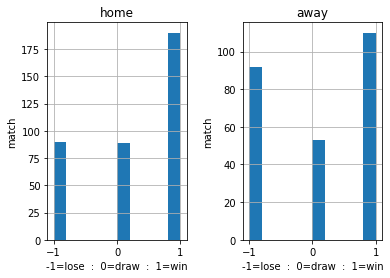

In [616]:
# df_japanからホームとアウェイに分類
home=df_japan[df_japan["japan_home_dummy"]==1]
away=df_japan[df_japan["japan_home_dummy"]==0]

# ホームの勝敗のグラフを作成
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
home["result"].hist(bins=10)

# X、Y軸とタイトルのラベル名を指定
ax1.set_xlabel("-1=lose  :  0=draw  :  1=win")
ax1.set_ylabel("match")
ax1.set_title("home")

# アウェイの勝敗のグラフを作成
ax2 = fig.add_subplot(1, 2, 2)
away["result"].hist(bins=10)

# X、Y軸とタイトルのラベル名を指定
ax2.set_xlabel("-1=lose  :  0=draw  :  1=win")
ax2.set_ylabel("match")
ax2.set_title("away")

# グラフ間のスペースを調整
plt.subplots_adjust(wspace=0.4)

plt.show()

次は勝敗別でホームとアウェイを確認します。

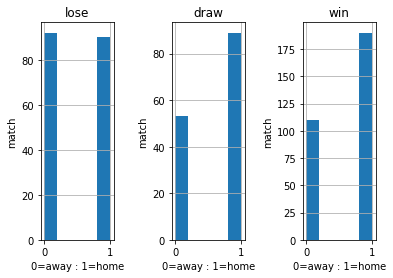

In [196]:
# 　df_japanから勝敗別に分類
lose=df_japan[df_japan["result"]==-1]
draw=df_japan[df_japan["result"]==0]
win=df_japan[df_japan["result"]==1]

# 負けた時のホームとアウェイのグラフを作成
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
lose["japan_home_dummy"].hist(bins=5)

# X、Y軸とタイトルのラベル名を指定
ax1.set_xlabel("0=away : 1=home")
ax1.set_ylabel("match")
ax1.set_title("lose")

# 引き分けのホームとアウェイのグラフを作成
ax2 = fig.add_subplot(1, 3, 2)
draw["japan_home_dummy"].hist(bins=5)

# X、Y軸とタイトルのラベル名を指定
ax2.set_xlabel("0=away : 1=home")
ax2.set_ylabel("match")
ax2.set_title("draw")

# 勝利した時のホームとアウェイのグラフを作成
ax3 = fig.add_subplot(1, 3, 3)
win["japan_home_dummy"].hist(bins=5)

# X、Y軸とタイトルのラベル名を指定
ax3.set_xlabel("0=away : 1=home")
ax3.set_ylabel("match")
ax3.set_title("win")

# グラフ間のスペースを調整
plt.subplots_adjust(wspace=0.8)

plt.show()

ホームだと勝率が高いのに対し、アウェイだと勝率が低いことが可視化されました。

## 3-1 出場国チームの選別
ワールドカップの出場枠は下記エリア毎の計32チームになります。`2-1`から勝率が高い順位に選別しました。
また選別に際して、FIFAランキングが１００位以下の国は出場率が非常に低いため今回は除外します。ここから今までの実績に基づいて優勝できる組み合わせを作成していきます。<br>
FIFAランキングはこちらのサイトから引用しています。（）内の数値はFIFAランキングです。（2019年12月19日発表）<br>
https://fifaranking.net/ranking/<br>

|南米|欧州|アフリカ|アジア|北中米カリブ海|オセアニア|出場国|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|4.5カ国|13カ国|4カ国|4.5カ国|3.5カ国|0.5カ国|1カ国|
|↓|↓|↓|↓|↓|↓|↓|
|アルゼンチン(９)|ベルギー(１)|チュニジア(27)|カタール(55)|アメリカ(22)| |日本(28)|
|コロンビア(10)|フランス(2)|アルジェリア(35)|サウジアラビア(67)|コスタリカ(46)| | |
|チリ(17)|デンマーク(16)|エジプト(51)|イラク(70)|カナダ(73)| | |
|エクアドル(63)|スウェーデン(17)|カメルーン(53)|シリア(79)|パナマ(81)| | |
|ボリビア（76)|ウクライナ(24)| |オマーン(82)| | | |
| |セルビア(29)| | | | | |
| |スロバキア(32)| | | | | |
| |アイスランド(39)| | | | | |
| |スコットランド(50)| | | | | |
| |ギリシャ(54)| | | | | |
| |フィンランド(58)| | | | | |
| |ブルガリア(59)| | | | | |
| |ルクセンブルク(98)| | | |




勝率の高い国から３２チームの選別が完了したのでいよいよ試合開始といきたいところですが、まずはワールドカップのルールから説明します。<br>
最初に４チーム総当たりのグループリーグを開始します。そこから負け０　引き分け１　勝利３　という換算で上位２チームが決勝トーナメントに進出です。
もし勝ち点が同じの場合、得失点差になります。

## 3-2 グループリーグの組み合わせ

組み合わせ方は、FIFAルールに則り振り分けていきます。ルールを詳しく知りたい方は下記ホームページを参考にして下さい。<br>
またFIFAの規定に則った上で日本が勝率の高い国と組み合わせていきます。<br>
https://national-soccer.com/2017/11/26/2018wc-draw/

|A|B|C|D|E|F|G|H|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|ベルギー（１）|フランス(2)|アルゼンチン(9)|コロンビア(10)|デンマーク(16)|チリ(17)|スウェーデン(17)|日本(28)|
|コスタリカ（４６）|アイスランド(39)|アルジェリア(35)|スロバキア(32)|セルビア(29)|チュニジア(27)|アメリカ(22)|ウクライナ(24)|
|スコットランド(50)|エジプト(51)|カメルーン（53）|ギリシャ（54）|カタール(55)|フィンランド(58)|ブルガリア(59)|エクアドル（63）|
|ルクセンブルク(98)|サウジアラビア(67)|パナマ(81)|シリア(79)|ボリビア(76)|カナダ(73)|オマーン(82)|イラク（70）|

## 3-3 勝敗の決め方

一番重要な部分になりますが、今回は過去の試合結果を基に勝敗を決める３つの要素を用意しました。<br>
<b>上記3点をもとに高い方に１点ずつ加え、試合の勝敗を決めていきたいと思います。</b>もし決勝トーナメントで同点の場合は、FIFAランキングが上位の国を勝利とします。試しに`日本VSイラク`で実行していきます。<br>
①７〜９月の勝率を足した合計値が高い方（例：７月勝率５３％＋８月４７％＋４９％＝１４９）<br>
②アウェイでの勝率が高い(日本のみホームの勝率で比較）<br>
③過去の試合結果から勝率の高い<br>

In [880]:
# イラクがホームかアウェイかを示すjapan_home_dummy列を作成
df_match["iraq_home_dummy"] = 0
df_match["iraq_home_dummy"][df_match["home_team"]=="Iraq"] = 1


# ホームチームが勝ったかどうかを示すhome_win列を作成
df_match["home_win"] = 0
df_match["home_win"][df_match["home_score"]>df_match["away_score"]] = 1
df_match["home_win"][df_match["home_score"]<df_match["away_score"]] = -1

# iraq_home_dummy列とhome_win列の値に基づいてresult列を作成
df_match["result"] = 0
#イラクがホームかつホームの点数が高い場合
df_match["result"][(df_match["iraq_home_dummy"]==1)&(df_match["home_win"]==1)] = 1
# イラクがホームかつアウェイの点数が高い場合
df_match["result"][(df_match["iraq_home_dummy"]==1)&(df_match["home_win"]==-1)]= -1
# イラクがアウェイかつホームの点数が高い場合
df_match["result"][(df_match["iraq_home_dummy"]==0)&(df_match["home_win"]==1)] = -1
# イラクがアウェイかつアウェイの点数が高い場合
df_match["result"][(df_match["iraq_home_dummy"]==0)&(df_match["home_win"]==-1)] = 1

# イラク戦のみ抽出
df_iraq = df_match.query('home_team == "Iraq" | away_team == "Iraq"')

### ①ホームの勝率で対戦

In [815]:
#日本のホームのみ抽出し、ホームでの総試合数を取得
home_japan = df_japan[df_japan["japan_home_dummy"]==1]
home_japan_result = len(home_japan.result) 
#ホームから勝利した回数を取得
home_japan_win = home_japan[home_japan["result"]==1]
home_japan_win2 = len(home_japan_win.result)
#ホームでの勝利数からホームの総試合数を割、勝率を算出
japan_result = (round(home_japan_win2 / home_japan_result *100))

In [943]:
#イラクのホームのみ抽出し、ホームでの総試合数を取得
away_iraq = df_iraq[df_iraq["iraq_home_dummy"]==0]
away_iraq_result = len(away_iraq.result)
#ホームから勝利した回数を取得
away_iraq_win = away_iraq[away_iraq["result"]==1]
away_iraq_win2 = len(away_iraq_win.result)
#ホームでの勝利数からホームの総試合数を割、勝率を算出
iraq_result = (round(away_iraq_win2 / away_iraq_result *100))

In [957]:
print('日本ホーム勝率:{0}%,　イラクアウェイ勝率:{1}%'.format(japan_result, iraq_result))

日本ホーム勝率:51%,　イラクアウェイ勝率:33%


### ②７〜９までの勝率で対戦

In [858]:
#dateを文字からIndexDateFrameに変換
df_japan["date"] = pd.to_datetime(df_japan["date"])
df_japan.set_index("date", inplace=True)
#dateから新しく月別の”month”カラムを作成
df_m_japan = df_japan.set_index([df_japan.index.month, df_japan.index])
df_m_japan.index.names = ["month", "date"]

In [884]:
#出力時にIndexが邪魔になるので削除
df_japan_jun = df_m_japan.reset_index()
#日本戦で7月に行われた試合を抽出、7月の総試合数を取得
df_jun_only = df_japan_jun[df_japan_jun["month"]==7]
df_jun_total = len(df_jun_only.result)
#7月から勝利した回数を取得
df_jun_win = df_jun_only[df_jun_only["result"]==1]
df_jun_win2 = len(df_jun_win.result)
#7月内の勝利数から7月の総勝利数を割、勝率を算出
japan_jun_result = (round(df_jun_win2 / df_jun_total *100))

In [885]:
#出力時にIndexが邪魔になるので削除
df_japan_aug = df_m_japan.reset_index()
#日本戦で８月に行われた試合を抽出、８月の総試合数を取得
df_aug_only = df_japan_aug[df_japan_aug["month"]==8]
df_aug_total = len(df_aug_only.result)
#８月から勝利した回数を取得
df_aug_win = df_aug_only[df_aug_only["result"]==1]
df_aug_win2 = len(df_aug_win.result)
#８月内の勝利数から８月の総勝利数を割、勝率を算出
japan_aug_result = (round(df_aug_win2 / df_aug_total *100))

In [887]:
#出力時にIndexが邪魔になるので削除
df_japan_sep = df_m_japan.reset_index()
#日本戦で9月に行われた試合を抽出、9月の総試合数を取得
df_sep_only = df_japan_sep[df_japan_sep["month"]==9]
df_sep_total = len(df_sep_only.result)
#9月から勝利した回数を取得
df_sep_win = df_sep_only[df_sep_only["result"]==1]
df_sep_win2 = len(df_sep_win.result)
#9月内の勝利数から9月の総勝利数を割、勝率を算出
japan_sep_result = (round(df_sep_win2 / df_sep_total *100))

In [881]:
#dateを文字からIndexDateFrameに変換
df_iraq["date"] = pd.to_datetime(df_iraq["date"])
df_iraq.set_index("date", inplace=True)
#dateから新しく月別の”month”カラムを作成
df_m_iraq = df_iraq.set_index([df_iraq.index.month, df_iraq.index])
df_m_iraq.index.names = ["month", "date"]

In [890]:
#出力時にIndexが邪魔になるので削除
df_iraq_jun = df_m_iraq.reset_index()
#イラク戦で7月に行われた試合を抽出、7月の総試合数を取得
df_jun_only = df_iraq_jun[df_iraq_jun["month"]==7]
df_jun_total = len(df_jun_only.result)
#7月から勝利した回数を取得
df_jun_win = df_jun_only[df_jun_only["result"]==1]
df_jun_win2 = len(df_jun_win.result)
#7月内の勝利数から7月の総勝利数を割、勝率を算出
iraq_jun_result = (round(df_jun_win2 / df_jun_total *100))

In [891]:
#出力時にIndexが邪魔になるので削除
df_iraq_aug = df_m_iraq.reset_index()
#イラク戦で８月に行われた試合を抽出、８月の総試合数を取得
df_aug_only = df_iraq_aug[df_iraq_aug["month"]==8]
df_aug_total = len(df_aug_only.result)
#８月から勝利した回数を取得
df_aug_win = df_aug_only[df_aug_only["result"]==1]
df_aug_win2 = len(df_aug_win.result)
#８月内の勝利数から８月の総勝利数を割、勝率を算出
iraq_aug_result = (round(df_aug_win2 / df_aug_total *100))

In [892]:
#出力時にIndexが邪魔になるので削除
df_iraq_sep = df_m_iraq.reset_index()
#イラク戦で9月に行われた試合を抽出、9月の総試合数を取得
df_sep_only = df_iraq_sep[df_iraq_sep["month"]==9]
df_sep_total = len(df_sep_only.result)
#9月から勝利した回数を取得
df_sep_win = df_sep_only[df_sep_only["result"]==1]
df_sep_win2 = len(df_sep_win.result)
#9月内の勝利数から9月の総勝利数を割、勝率を算出
iraq_sep_result = (round(df_sep_win2 / df_sep_total *100))

In [895]:
#7~9月の勝率の和を取得
japan_seson_result = japan_jun_result + japan_aug_result + japan_sep_result
iraq_seson_result = iraq_jun_result + iraq_aug_result + iraq_sep_result

In [956]:
print('日本7~9月勝率:{0},　イラク7~9月勝率:{1}'.format(japan_seson_result, iraq_seson_result))

日本7~9月勝率:158,　イラク7~9月勝率:146


### ③過去の試合結果の勝率で対戦

In [977]:
#日本VSイラクの過去の試合結果を確認。
japan_iraq = df_japan.reset_index()
japan_iraq = japan_iraq.query('home_team == "Iraq" | away_team == "Iraq"')
#過去の勝利数を求める
japan_iraq_result = japan_iraq["result"].sum()

In [978]:
#イラクVS日本の過去の試合結果を確認。
iraq_japan = df_iraq.reset_index()
iraq_japan = iraq_japan.query('home_team == "Japan" | away_team == "Japan"')
#過去の勝利数を求める
iraq_japan_result = iraq_japan["result"].sum()

In [979]:
print('日本勝利数:{0}回,　イラク勝利数:{1}回'.format(japan_iraq_result, iraq_japan_result))

日本勝利数:6回,　イラク勝利数:-6回


### ①〜③の結果をまとめ

In [1011]:
#日本対イラクの①〜③までの対戦結果を格納するクラスを作成
japan_final = 0
iraq_final = 0

#①の結果を格納
if japan_result > iraq_result:
    japan_final += 1
elif japan_result < iraq_result:
    iraq_final += 1
else: 
    pass
#②の結果を格納   
if japan_seson_result > iraq_seson_result:
    japan_final += 1
elif japan_seson_result < iraq_seson_result:
    iraq_final += 1
else:
    pass
    
#③の結果を格納    
if japan_iraq_result > iraq_japan_result:
    japan_final += 1
elif japan_iraq_result < iraq_seson_result:
    iraq_final += 1
else:
    pass

In [1012]:
#①〜③までの結果出力
print("日本{0}-{1}イラク".format(japan_final, iraq_final))

日本3-0イラク


今回の試合は日本の勝利となりました。このように①〜③の各要素で対戦し勝敗を各国決めたのが下記になります。<br>
グループリーグや決勝トーナメントの組み合わせついては、分析上日本が勝利できることと、現実性の高い国が勝ち上がるようにしました。<br>
現実性の高い国とはW杯の過去の結果から決勝トーナメントに勝ち上がるのはFIFAランキングが高い国の傾向があります。なるべくそれに沿った組み合わせにしてみました。

## 3-4 試合結果
まずはグループリーグの勝敗結果です。(README.mdの①に格納)
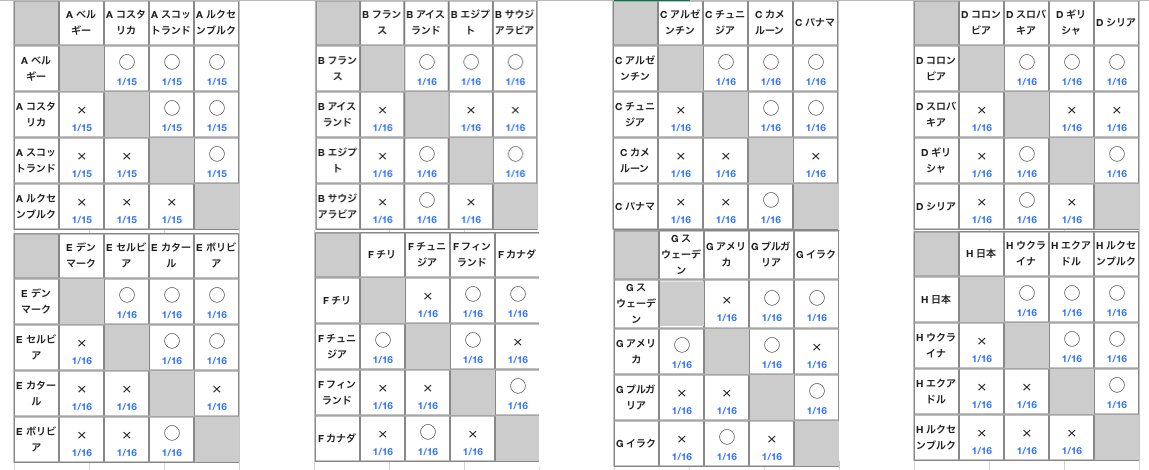
次に決勝トーナメントの試合結果です。(README.md②に格納)
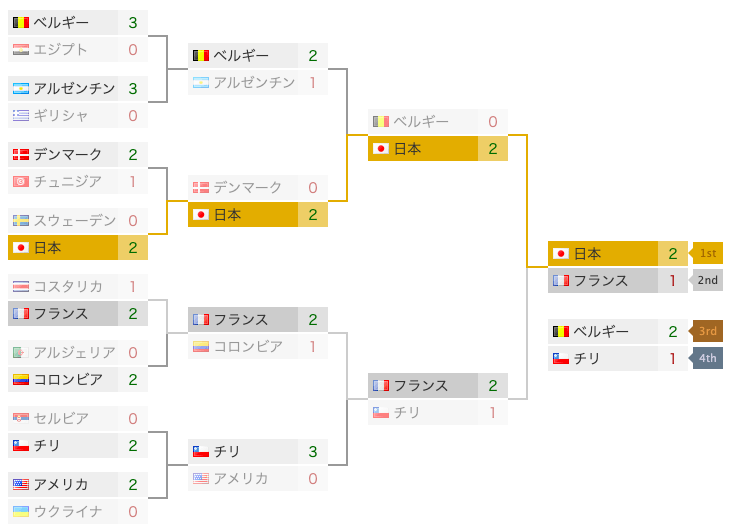

こちらで分析は以上になります。皆さん結果をみてどう思うでしょか。ベルギーやフランスといった強豪相手に本当に勝てるのか？と思うかもしれません。ただ分析上、大会の条件を絞れば数値上勝てるわけです！！<br>
次回のW杯開催国のチャンスは<b>2030年W杯</b>です。日本はずっとW杯を誘致しているので、2024年に行われるFIFA総会で開催地を選ぶことが予定されています。日本の夢である<b>優勝</b>を目指すためには今回分析した条件で誘致できることを願っています。<br>

## 4 最後に

ちょっとした気持ちで学んだばかりのPythonを活かして分析をしてみたら、楽しくて止まらなくなってしまいました。まだまだ分析のレベルとしては低いものですが今後多くの成果物を作成しながら自身の知見を広げていければと思います。<br>
とりあえずPythonもGitHubも、まず１歩